In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


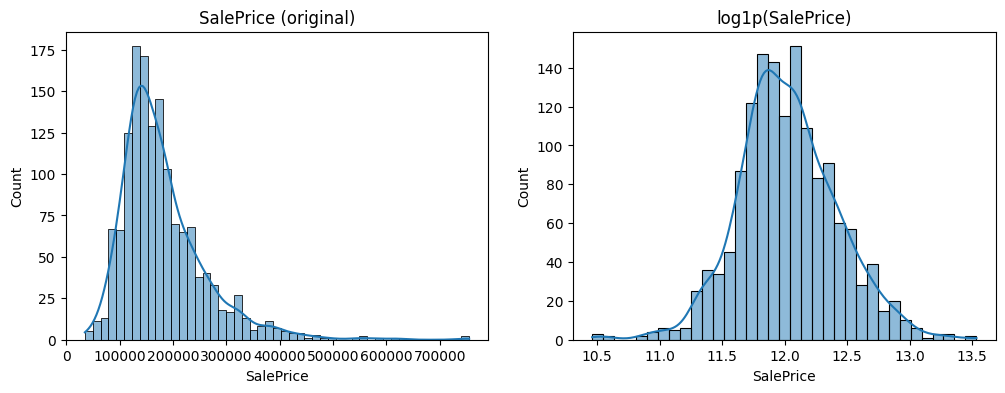

In [2]:
# ① Imports & Load
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor

# 路径：Kaggle 默认
DATA_DIR = "/kaggle/input/house-prices-advanced-regression-techniques"

train = pd.read_csv(f"{DATA_DIR}/train.csv")
test  = pd.read_csv(f"{DATA_DIR}/test.csv")

# 目标对数化（评测使用 RMSE/对数更稳）
y_log = np.log1p(train["SalePrice"])  # y 的 log1p
n_train = len(train)                  # 训练行数（后面切分用）
train_feat = train.drop(columns=["SalePrice"])  # 仅特征

# ——可视化：目标原尺度 vs 对数（只需一次）
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(train["SalePrice"], kde=True, ax=ax[0]); ax[0].set_title("SalePrice (original)")
sns.histplot(y_log, kde=True, ax=ax[1]); ax[1].set_title("log1p(SalePrice)")
plt.show()

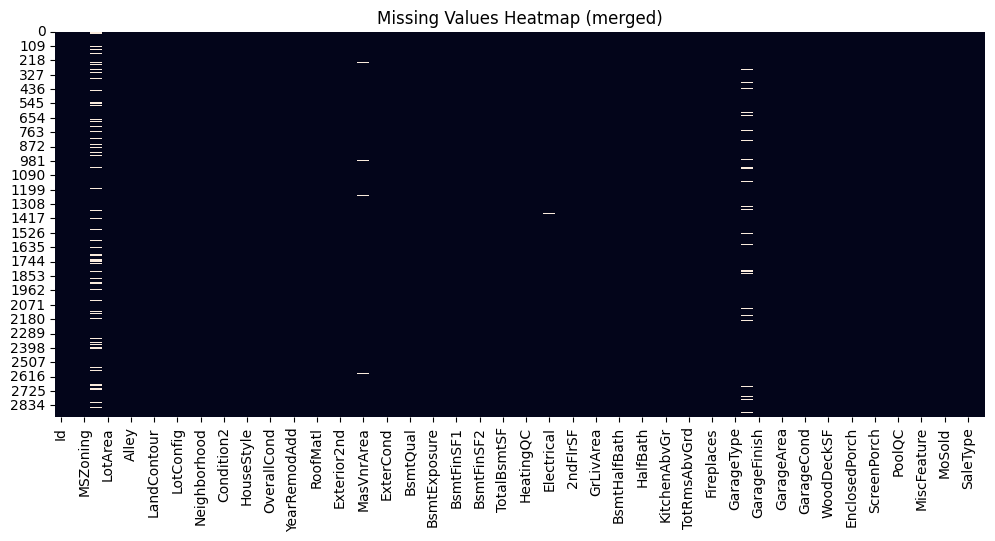

In [3]:
# ② 合并（不含目标，没有ScalePrice）
full = pd.concat([train_feat, test], axis=0, ignore_index=True)

# 明确“缺失=没有该设施”的类别列 => 填 'None'
na_none_cols = [
    "Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
    "FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
    "PoolQC","Fence","MiscFeature","MasVnrType"
]
for c in na_none_cols:
    if c in full.columns:
        full[c] = full[c].fillna("None")

# 语义为类别的数字列转字符串
if "MSSubClass" in full.columns:
    full["MSSubClass"] = full["MSSubClass"].astype(str)

# ——可视化：缺失值热图（概览一次即可）
plt.figure(figsize=(12,5))
sns.heatmap(full.isnull(), cbar=False)
plt.title("Missing Values Heatmap (merged)")
plt.show()

In [4]:
# ③ 新特征：注意先把参与运算的列 NaN->0/中位数，避免产生 NaN
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()

    def z(col):  # 存在则取并填0，不存在返回0
        return d[col].fillna(0) if col in d.columns else 0
    def m(col):  # 用中位数兜底做差分
        return d[col].fillna(d[col].median()) if col in d.columns else 0

    d["TotalSF"]   = z("TotalBsmtSF") + z("1stFlrSF") + z("2ndFlrSF")
    d["TotalBath"] = z("FullBath") + 0.5*z("HalfBath") + z("BsmtFullBath") + 0.5*z("BsmtHalfBath")
    d["HouseAge"]  = m("YrSold") - m("YearBuilt")
    d["RemodAge"]  = m("YrSold") - m("YearRemodAdd")
    d["GarageAge"] = m("YrSold") - m("GarageYrBlt")
    d["IsRemodeled"] = ((d.get("YearBuilt", m("YearBuilt"))) != (d.get("YearRemodAdd", m("YearRemodAdd")))).astype(int)
    d["HasBsmt"]   = (z("TotalBsmtSF") > 0).astype(int)
    d["Has2ndFlr"] = (z("2ndFlrSF") > 0).astype(int)
    d["HasPool"]   = ((z("PoolArea") > 0) | (d.get("PoolQC", "None") != "None")).astype(int)

    if "OverallQual" in d.columns and "GrLivArea" in d.columns:
        d["Qual_LivArea"] = d["OverallQual"].fillna(0) * d["GrLivArea"].fillna(0)

    return d

full = add_features(full)

# 切回训练 / 测试特征
X = full.iloc[:n_train, :].copy()
X_test_final = full.iloc[n_train:, :].copy()

# 强制去掉不参与建模的 Id
for df_ in (X, X_test_final):
    if "Id" in df_.columns:
        df_.drop(columns=["Id"], inplace=True)

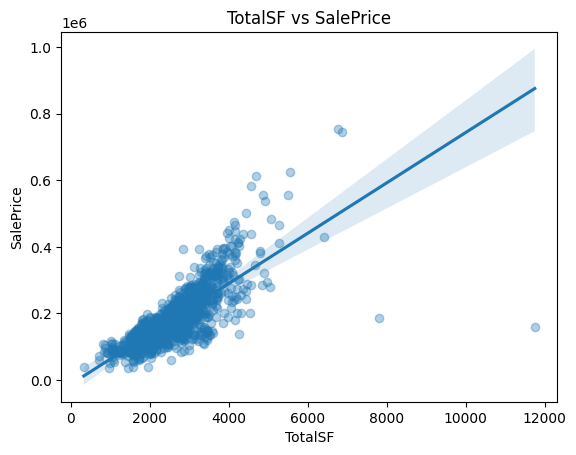

In [5]:
# ④ 只为可视化：把目标（原尺度）并回训练特征的一份拷贝
df_vis = X.copy()
df_vis["SalePrice"] = np.expm1(y_log)
df_vis = df_vis.replace([np.inf, -np.inf], np.nan).dropna(subset=["TotalSF", "SalePrice"])

# ——可视化：连续×连续更适合散点 + 趋势线
sns.regplot(x="TotalSF", y="SalePrice", data=df_vis, scatter_kws={"alpha":0.35})
plt.title("TotalSF vs SalePrice")
plt.show()

In [6]:
# ⑤ 列类型识别
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# 预处理：数值&类别分支
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("power",   PowerTransformer(method="yeo-johnson"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `s

Ridge      CV RMSE: 0.13328 ± 0.02468


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `s

Lasso      CV RMSE: 0.12799 ± 0.02521


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `s

ElasticNet CV RMSE: 0.12800 ± 0.02504


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `s

HGBR       CV RMSE: 0.13623 ± 0.01837


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


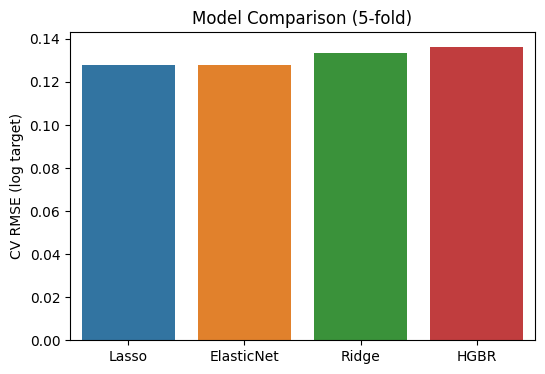

In [7]:
# ⑥ 多模型 5 折交叉验证（指标：neg_root_mean_squared_error）
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor

ridge = Ridge(alpha=5.0, random_state=42)
lasso = Lasso(alpha=5e-4, max_iter=20000, random_state=42)
enet  = ElasticNet(alpha=5e-4, l1_ratio=0.9, max_iter=20000, random_state=42)
hgb   = HistGradientBoostingRegressor(learning_rate=0.05, max_bins=255,
                                      early_stopping=True, random_state=42)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
metric = "neg_root_mean_squared_error"

def cv_rmse(estimator):
    pipe = Pipeline([("prep", preprocess), ("model", estimator)])
    scores = cross_val_score(pipe, X, y_log, cv=cv, scoring=metric, n_jobs=-1)
    return -scores.mean(), scores.std()

results = []
for name, model in [("Ridge", ridge), ("Lasso", lasso), ("ElasticNet", enet), ("HGBR", hgb)]:
    mean_rmse, std_rmse = cv_rmse(model)
    results.append((name, mean_rmse))
    print(f"{name:10s} CV RMSE: {mean_rmse:.5f} ± {std_rmse:.5f}")

# ——可视化：模型 RMSE 对比
plt.figure(figsize=(6,4))
names, scores = zip(*sorted(results, key=lambda x: x[1]))
sns.barplot(x=list(names), y=list(scores))
plt.ylabel("CV RMSE (log target)"); plt.title("Model Comparison (5-fold)")
plt.show()

In [8]:
# ⑦ 简洁 Stacking
stack = Pipeline([
    ("prep", preprocess),
    ("model", StackingRegressor(
        estimators=[
            ("ridge", ridge),
            ("lasso", lasso),
            ("enet",  enet),
            ("hgb",   hgb),
        ],
        final_estimator=Ridge(alpha=1.0, random_state=42),
        passthrough=False,
        n_jobs=-1
    ))
])

stack_scores = cross_val_score(stack, X, y_log, cv=cv, scoring=metric, n_jobs=-1)
print(f"Stacking   CV RMSE: {-stack_scores.mean():.5f} ± {stack_scores.std():.5f}")

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `s

Stacking   CV RMSE: 0.12585 ± 0.02351


In [9]:
# ⑧ 拟合全量训练集并预测测试集
stack.fit(X, y_log)
y_pred_log = stack.predict(X_test_final)
y_pred = np.expm1(y_pred_log)  # 还原回原尺度价格

sub = pd.DataFrame({"Id": test["Id"], "SalePrice": y_pred})
sub.to_csv("submission.csv", index=False)
print("Saved: submission.csv")

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Saved: submission.csv
